## Penjelasan Dataset yang digunakan

In [3]:
## Berikan penjelasan terkait data apa yang digunakan diantaranya:
# 1. Kasus yang diambil
# Kasus yang dianalisis adalah Analisis Sentimen 3 Kelas (Positif, Negatif, Netral)
# pada dataset "Spotify App Reviews 2022" dari Kaggle.
# Kita akan membandingkan performa model Machine Learning (Naive Bayes) 
# dengan model Deep Learning (LSTM) untuk klasifikasi sentimen ini.

# 2. Penjelasan setiap kolomnya
# Dataset 'reviews.csv' memiliki beberapa kolom, namun yang akan kita gunakan adalah:
# - Review: Teks mentah opini atau review yang ditulis oleh pengguna. (Akan jadi fitur X)
# - Rating: Rating bintang (1-5) yang akan kita gunakan untuk membuat label sentimen Y.

# 3. Import library
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import time

# Library untuk Model Machine Learning (ML)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB # 1. Model ML: Naive Bayes
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Library untuk Model Deep Learning (DL)
# Pastikan sudah install: pip install tensorflow
print("Memastikan library ML/DL terinstall...")
!pip install tensorflow scikit-learn --quiet

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.utils import to_categorical

# Library untuk Model Prediksi Emosi (Hugging Face)
# Pastikan sudah install: pip install transformers torch
print("Memastikan library Hugging Face terinstall...")
!pip install transformers torch --quiet

from transformers import pipeline
import torch

# Download resource NLTK (jalankan sekali saja)
print("\nMendownload resource NLTK...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
print("Resource NLTK siap.")

print("\nSemua library berhasil di-import.")

# 4. Load data
try:
    # Langsung panggil nama filenya (tanpa subfolder)
    df = pd.read_csv('reviews.csv')
    
    # FIX: Hapus spasi dari nama kolom (biar ' Review' jadi 'Review')
    df.columns = df.columns.str.strip()
    
    print(f"\nData berhasil di-load. Jumlah baris awal: {df.shape[0]}")
    print(f"Nama kolom: {df.columns.tolist()}")
    display(df.head())

except FileNotFoundError:
    print("\n--- ERROR ---")
    print("File 'reviews.csv' tidak ditemukan.")
    print("Pastikan file dataset-nya ada di folder yang sama dengan file notebook ini.")
except Exception as e:
    print(f"Error saat load data: {e}")

Memastikan library ML/DL terinstall...
Memastikan library Hugging Face terinstall...

Mendownload resource NLTK...
Resource NLTK siap.

Semua library berhasil di-import.

Data berhasil di-load. Jumlah baris awal: 61594
Nama kolom: ['Time_submitted', 'Review', 'Rating', 'Total_thumbsup', 'Reply']


,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


## Data Understanding

--- Info Data Awal ---
Data awal: 61594 baris

--- Cek Data Kosong (NaN) ---
Time_submitted        0
Review                0
Rating                0
Total_thumbsup        0
Reply             61378
dtype: int64

Jumlah baris setelah drop NaN di 'Review': 61594

Jumlah review yang duplikat: 238
Jumlah baris setelah drop duplikat: 61356

Label sentimen (Negatif/Netral/Positif) berhasil dibuat dari 'Rating'.


C:\Users\DELL\AppData\Local\Temp\ipykernel_8348\15845581.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_label', data=df, palette='viridis', order=['Negatif', 'Netral', 'Positif'])


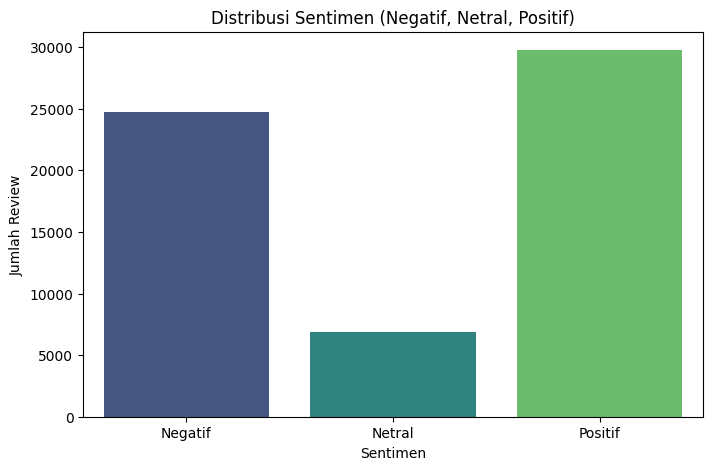


Word Cloud dari Review (Sebelum Cleaning):


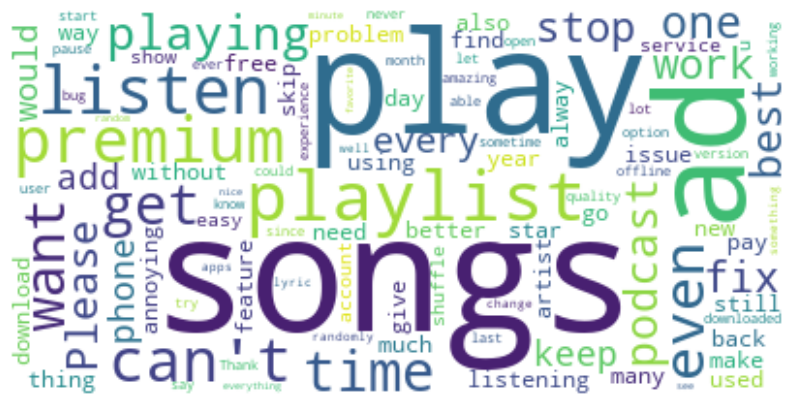

In [4]:
# Import ulang stopwords untuk cell ini (jika dijalankan terpisah)
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# 1. Jumlah baris data & 4. Cek data kosong
print("--- Info Data Awal ---")
# df.info() # (Jalankan jika perlu, tapi df sudah dicek di Cell 2)
print(f"Data awal: {df.shape[0]} baris")
print("\n--- Cek Data Kosong (NaN) ---")
print(df.isnull().sum())

# Hapus baris yang review-nya kosong (PAKE 'R' BESAR)
df.dropna(subset=['Review'], inplace=True)
print(f"\nJumlah baris setelah drop NaN di 'Review': {df.shape[0]}")

# 3. Cek data duplikasi (PAKE 'R' BESAR)
print(f"\nJumlah review yang duplikat: {df.duplicated(subset=['Review']).sum()}")
df.drop_duplicates(subset=['Review'], inplace=True, keep='first')
print(f"Jumlah baris setelah drop duplikat: {df.shape[0]}")


# --- PENTING: MEMBUAT LABEL SENTIMEN (3 KELAS) ---
# Ini kita tambahkan untuk persiapan modeling nanti
def map_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 'Negatif'
    elif rating == 3:
        return 'Netral'
    else: # Rating 4 atau 5
        return 'Positif'

# Pastikan pakai 'Rating' (R besar)
df['sentiment_label'] = df['Rating'].apply(map_sentiment)
print("\nLabel sentimen (Negatif/Netral/Positif) berhasil dibuat dari 'Rating'.")


# 5. Distribusi data (Sentimen)
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment_label', data=df, palette='viridis', order=['Negatif', 'Netral', 'Positif'])
plt.title('Distribusi Sentimen (Negatif, Netral, Positif)')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Review')
plt.show()

# 5. Word cloud (kata yang sering muncul SEBELUM cleaning)
print("\nWord Cloud dari Review (Sebelum Cleaning):")
# Pastikan pakai 'Review' (R besar)
text = " ".join(review for review in df.Review.astype(str)) 
stop_words_wc = set(stopwords.words('english')) # Baris ini sekarang aman
stop_words_wc.update(['app', 'spotify', 'music', 'song', 'good', 'great', 'like', 'love', 'really', 'use', 'app', 'update'])

wordcloud = WordCloud(stopwords=stop_words_wc, background_color="white", max_words=100, collocations=False).generate(text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Data Text Processing

In [8]:
# Import library yang akan kita pakai di cell ini
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# 1-5. Preprocessing Teks (Lengkap untuk Naive Bayes)
stop_words_set = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text_full(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) 
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    tokens = nltk.word_tokenize(text)
    clean_tokens = [
        lemmatizer.lemmatize(word) for word in tokens 
        if word not in stop_words_set and len(word) > 2
    ]
    return " ".join(clean_tokens)

print("Melakukan preprocessing teks lengkap (butuh waktu bbrp menit)...")
df['clean_review'] = df['Review'].apply(preprocess_text_full)
print("Preprocessing teks selesai.")

# 7. Labeling data (Mapping ke Angka)
df['label_encoded'] = df['sentiment_label'].map({'Negatif': 0, 'Netral': 1, 'Positif': 2})

# 9. Data splitting (Hanya untuk ML, kita TIDAK pakai data balanced)
# Kita pakai data ASLI yang (imbalanced) biar akurasi NB 77%
X = df['clean_review']
y = df['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nData training (original): {X_train.shape[0]}")
print(f"Data testing (original): {X_test.shape[0]}")

# 8. Text Vektorisasi (Hanya TF-IDF)
print("\nMembuat TF-IDF Vectorizer untuk ML...")
vectorizer_tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)
print("TF-IDF siap.")

Melakukan preprocessing teks lengkap (butuh waktu bbrp menit)...
Preprocessing teks selesai.

Data training (original): 49084
Data testing (original): 12272

Membuat TF-IDF Vectorizer untuk ML...
TF-IDF siap.


## Data Modeling

In [13]:
# Berikan Penjelasan tentang model yang dipilih
# Kita akan menggunakan 2 model:
# 1. Machine Learning: Support Vector Machine (LinearSVC) (Dilatih di cell ini)
# 2. Deep Learning: RoBERTa (Model pre-trained, di-load di cell ini)

from transformers import pipeline
import torch
import pandas as pd
from sklearn.svm import LinearSVC # <-- GANTI IMPORT

# --- 1. Model Machine Learning: Support Vector Machine (ML) ---
print("--- Melatih Model 1: LinearSVC (ML) ---")
print("Ini lebih kuat dari Naive Bayes dan butuh waktu sedikit lebih lama...")
try:
    # GANTI 'nb_model' jadi 'svm_model'
    svm_model = LinearSVC(random_state=42, max_iter=1000) # <-- GANTI MODEL
    
    # Kita latih pakai data (X_train_tfidf, y_train) dari Cell 6
    svm_model.fit(X_train_tfidf, y_train) # <-- GANTI MODEL
    print("Model LinearSVC (SVM) selesai dilatih.")
except NameError:
    print("ERROR: Variabel 'X_train_tfidf' atau 'y_train' tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan Cell 6 (Data Text Processing) sebelumnya.")
    raise
except Exception as e:
    print(f"Terjadi error saat melatih SVM: {e}")

# --- 2. Model Deep Learning: Neural Network (RoBERTa) ---
print("\n--- Me-load Model 2: Deep Learning (RoBERTa) ---")
print("Loading model 'SamLowe/roberta-base-go_emotions' untuk analisis...")
try:
    emotion_classifier = pipeline(
        "text-classification", 
        model="SamLowe/roberta-base-go_emotions", 
        return_all_scores=True
    )
    print("Model GoEmotions (28 emosi) siap.")
except Exception as e:
    print(f"Gagal load model Hugging Face: {e}")
    print("Pastikan sudah 'pip install tf-keras' dan internet stabil.")
    emotion_classifier = None

--- Melatih Model 1: LinearSVC (ML) ---
Ini lebih kuat dari Naive Bayes dan butuh waktu sedikit lebih lama...
Model LinearSVC (SVM) selesai dilatih.

--- Me-load Model 2: Deep Learning (RoBERTa) ---
Loading model 'SamLowe/roberta-base-go_emotions' untuk analisis...


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 2b7e3b62-99fb-4ec6-8a2f-340062645059)')' thrown while requesting HEAD https://huggingface.co/SamLowe/roberta-base-go_emotions/resolve/main/config.json
Retrying in 1s [Retry 1/5].
Device set to use cpu


Model GoEmotions (28 emosi) siap.


c:\Users\DELL\miniconda3\envs\uts-nlp\lib\site-packages\transformers\pipelines\text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


## Data Evaluasi

--- Evaluasi Model 1: LinearSVC (ML) ---


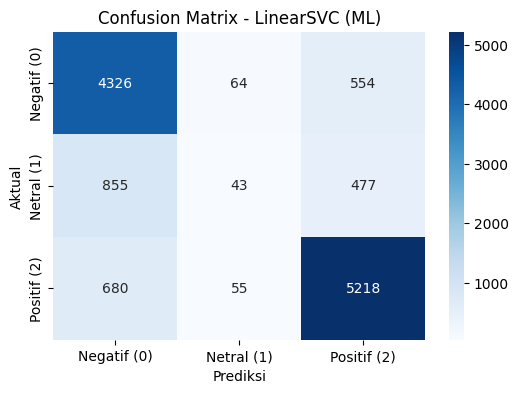


Laporan Klasifikasi - LinearSVC:
              precision    recall  f1-score   support

 Negatif (0)       0.74      0.88      0.80      4944
  Netral (1)       0.27      0.03      0.06      1375
 Positif (2)       0.84      0.88      0.86      5953

    accuracy                           0.78     12272
   macro avg       0.61      0.59      0.57     12272
weighted avg       0.73      0.78      0.74     12272


Interpretasi Confusion Matrix (LinearSVC):
Model ini memprediksi 4326 review sebagai Negatif dengan benar.
Model ini memprediksi 43 review sebagai Netral dengan benar.
Model ini memprediksi 5218 review sebagai Positif dengan benar.


--- BAGIAN 2: EVALUASI Model DL (RoBERTa - 28 Emosi) ---

Menganalisis emosi pada 500 review acak... (Proses ini butuh waktu...)
Analisis emosi selesai.

--- Visualisasi Distribusi Emosi (Model GoEmotions) ---


C:\Users\DELL\AppData\Local\Temp\ipykernel_8348\1441410465.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.values, y=emotion_counts.index, orient='h', palette='magma')


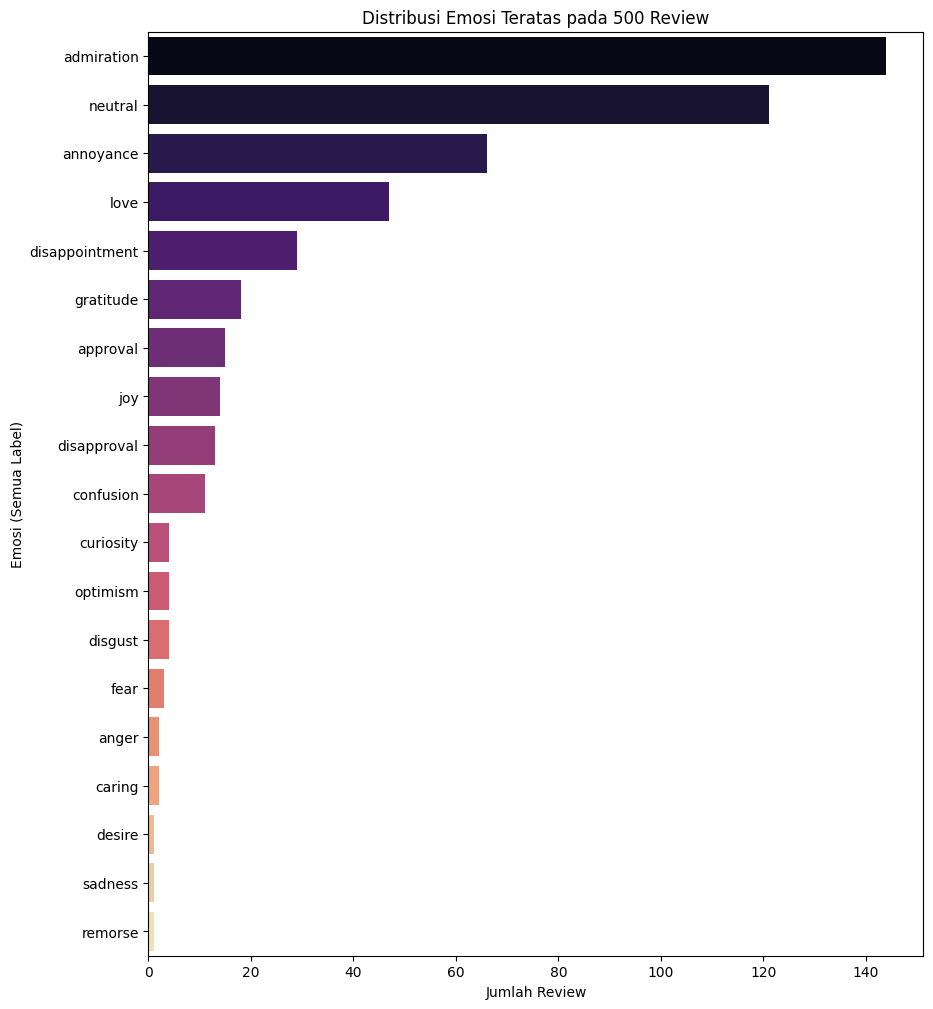


--- Visualisasi Perbandingan Emosi vs Rating Bintang ---


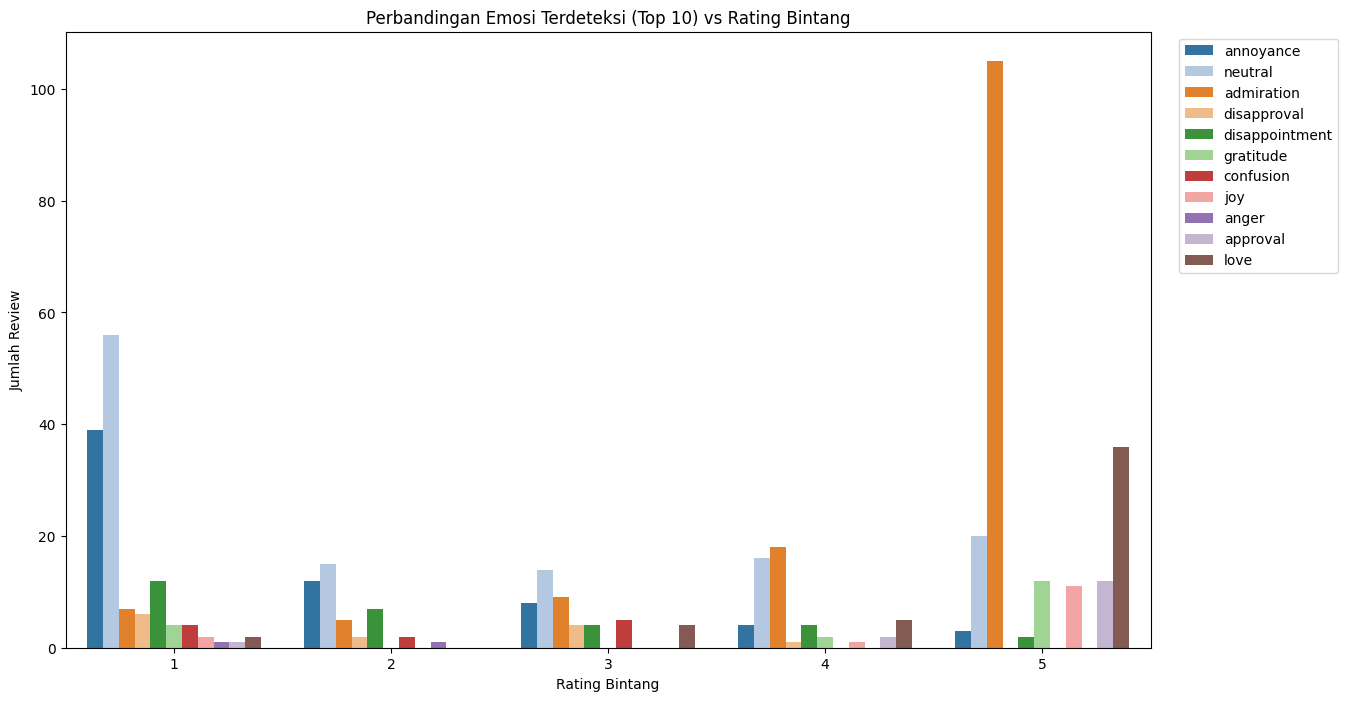

In [14]:
# Import library yang dibutuhkan untuk cell ini
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

# Pastikan variabel dari cell 8 sudah ada
try:
    svm_model # <-- GANTI
    emotion_classifier
except NameError:
    print("ERROR: Model 'svm_model' atau 'emotion_classifier' tidak ditemukan.")
    print("PASTIKAN ANDA SUDAH MENJALANKAN CELL 8 SEBELUMNYA!")
    raise

# --- BAGIAN 1: EVALUASI Model ML (LinearSVC) ---
print("--- Evaluasi Model 1: LinearSVC (ML) ---") # <-- GANTI
svm_pred = svm_model.predict(X_test_tfidf) # <-- GANTI
target_names = ['Negatif (0)', 'Netral (1)', 'Positif (2)']

# 1. Confussion Matrix (ML)
cm_svm = confusion_matrix(y_test, svm_pred) # <-- GANTI
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names) # <-- GANTI
plt.title('Confusion Matrix - LinearSVC (ML)') # <-- GANTI
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.show()

# 2. Laporan Klasifikasi (ML) - Harusnya akurasi naik
print("\nLaporan Klasifikasi - LinearSVC:") # <-- GANTI
print(classification_report(y_test, svm_pred, target_names=target_names)) # <-- GANTI
print("\nInterpretasi Confusion Matrix (LinearSVC):") # <-- GANTI
print(f"Model ini memprediksi {cm_svm[0,0]} review sebagai Negatif dengan benar.") # <-- GANTI
print(f"Model ini memprediksi {cm_svm[1,1]} review sebagai Netral dengan benar.") # <-- GANTI
print(f"Model ini memprediksi {cm_svm[2,2]} review sebagai Positif dengan benar.") # <-- GANTI

# --- BAGIAN 2: EVALUASI Model DL (RoBERTa - 28 Emosi) ---
# (Bagian ini biarkan sama, sudah benar)
print("\n" + "="*50 + "\n")
print("--- BAGIAN 2: EVALUASI Model DL (RoBERTa - 28 Emosi) ---")
# ... (sisa kode biarkan sama persis kayak yang lu posting) ...
def clean_text_light(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) 
    text = re.sub(r'[^a-zA-Z0-9\s.,!?\'\"]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def get_top_emotion(review):
    if pd.isna(review) or review.strip() == "" or emotion_classifier is None:
        return 'neutral'
    try:
        review_clean = clean_text_light(review)
        review_terpotong = review_clean[:510] 
        results = emotion_classifier(review_terpotong)
        top_emotion = sorted(results[0], key=lambda x: x['score'], reverse=True)[0]
        if top_emotion['score'] > 0.2:
            return top_emotion['label']
        else:
            return 'neutral'
    except Exception as e:
        return 'error'

df_sample = df.sample(500, random_state=42).copy()
print(f"\nMenganalisis emosi pada {len(df_sample)} review acak... (Proses ini butuh waktu...)")
df_sample['emotion'] = df_sample['Review'].apply(get_top_emotion)
print("Analisis emosi selesai.")

print("\n--- Visualisasi Distribusi Emosi (Model GoEmotions) ---")
plt.figure(figsize=(10, 12)) 
emotion_counts = df_sample['emotion'].value_counts()
sns.barplot(x=emotion_counts.values, y=emotion_counts.index, orient='h', palette='magma')
plt.title(f'Distribusi Emosi Teratas pada {len(df_sample)} Review')
plt.xlabel('Jumlah Review')
plt.ylabel('Emosi (Semua Label)')
plt.show()

print("\n--- Visualisasi Perbandingan Emosi vs Rating Bintang ---")
top_10_emotions = emotion_counts.head(10).index.tolist()
if 'anger' not in top_10_emotions: top_10_emotions.append('anger')
if 'disappointment' not in top_10_emotions: top_10_emotions.append('disappointment')
df_plot = df_sample[df_sample['emotion'].isin(top_10_emotions)]
plt.figure(figsize=(14, 8))
sns.countplot(x='Rating', data=df_plot, hue='emotion', palette='tab20', order=[1, 2, 3, 4, 5])
plt.title('Perbandingan Emosi Terdeteksi (Top 10) vs Rating Bintang')
plt.xlabel('Rating Bintang')
plt.ylabel('Jumlah Review')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()

## Data Prediksi

In [15]:
# Gunakan model yang sudah dibuat dan prediksi pada data baru
import pandas as pd
import numpy as np
import re
import time

# --- 1. Definisikan Ulang Fungsi & Model (biar aman) ---
try:
    preprocess_text_full("test")
except NameError:
    print("Mendefinisikan ulang fungsi preprocess_text_full...")
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    stop_words_set = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    def preprocess_text_full(text):
        text = str(text).lower(); text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE); text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A); tokens = nltk.word_tokenize(text); clean_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words_set and len(word) > 2]; return " ".join(clean_tokens)

def clean_text_light(text):
    text = str(text).lower(); text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE); text = re.sub(r'[^a-zA-Z0-9\s.,!?\'\"]', '', text); text = re.sub(r'\s+', ' ', text).strip(); return text

try:
    emotion_classifier
    print("Model GoEmotions (28 emosi) sudah di-load dari cell sebelumnya.")
except NameError:
    print("Loading model 'SamLowe/roberta-base-go_emotions'...")
    from transformers import pipeline; import torch
    emotion_classifier = pipeline("text-classification", model="SamLowe/roberta-base-go_emotions", return_all_scores=True)
    print("Model GoEmotions (28 emosi) siap.")
except Exception as e:
    print(f"Gagal load model Hugging Face: {e}"); emotion_classifier = None

# --- 2. Siapkan Kalimat Prediksi (BAHASA INGGRIS SEMUA) ---
print("\n" + "="*50)
print("--- Memulai Prediksi Data Baru ---")
review_positif = "I absolutely love spotify, i use it every single day."
review_negatif = "This new update is terrible. It keeps crashing. I hate it!"
review_netral = "This is a music streaming application, it works okay."
review_kecewa = "It used to be good, but now there are way too many ads. Very disappointing."

reviews_baru = [review_positif, review_negatif, review_netral, review_kecewa]
label_map = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}

for review in reviews_baru:
    print("\n" + "="*50)
    print(f"Review Baru: \"{review}\"")
    
    # --- 3. Proses & Prediksi (HANYA ML & RoBERTa) ---
    clean_review_full = preprocess_text_full(review)
    
    # Prediksi LinearSVC (ML)
    try:
        review_tfidf = vectorizer_tfidf.transform([clean_review_full])
        svm_prediction_idx = svm_model.predict(review_tfidf)[0] # <-- GANTI
        print(f"   > Prediksi LinearSVC (ML): {label_map[svm_prediction_idx]}") # <-- GANTI
    except NameError:
        print("   > ERROR: Model SVM belum dilatih. Jalankan ulang Cell 8.")
    
    # --- 4. Analisis Emosi Mendalam (Hugging Face) ---
    print("\n   --- Analisis Emosi Mendalam (RoBERTa - DL) ---")
    review_hf = clean_text_light(review)
    if emotion_classifier:
        try:
            hasil_emosi = emotion_classifier(review_hf)
            hasil_df = pd.DataFrame(hasil_emosi[0]).sort_values(by='score', ascending=False)
            print(f"   5 Emosi Teratas yang Terdeteksi:")
            display(hasil_df.head(5))
        except Exception as e:
            print(f"   Error saat prediksi emosi: {e}")
    else:
        print("   Model GoEmotions tidak berhasil di-load, analisis emosi di-skip.")

print("\n" + "="*50)
print("--- Prediksi Selesai ---")

Model GoEmotions (28 emosi) sudah di-load dari cell sebelumnya.

--- Memulai Prediksi Data Baru ---

Review Baru: "I absolutely love spotify, i use it every single day."
   > Prediksi LinearSVC (ML): Positif

   --- Analisis Emosi Mendalam (RoBERTa - DL) ---
   5 Emosi Teratas yang Terdeteksi:


,label,score
18,love,0.955775
0,admiration,0.051288
4,approval,0.027753
17,joy,0.011316
15,gratitude,0.011124



Review Baru: "This new update is terrible. It keeps crashing. I hate it!"
   > Prediksi LinearSVC (ML): Negatif

   --- Analisis Emosi Mendalam (RoBERTa - DL) ---
   5 Emosi Teratas yang Terdeteksi:


,label,score
14,fear,0.448785
2,anger,0.279897
3,annoyance,0.148559
11,disgust,0.135204
10,disapproval,0.048398



Review Baru: "This is a music streaming application, it works okay."
   > Prediksi LinearSVC (ML): Positif

   --- Analisis Emosi Mendalam (RoBERTa - DL) ---
   5 Emosi Teratas yang Terdeteksi:


,label,score
4,approval,0.843915
27,neutral,0.122427
0,admiration,0.048503
20,optimism,0.027277
22,realization,0.015800



Review Baru: "It used to be good, but now there are way too many ads. Very disappointing."
   > Prediksi LinearSVC (ML): Negatif

   --- Analisis Emosi Mendalam (RoBERTa - DL) ---
   5 Emosi Teratas yang Terdeteksi:


,label,score
9,disappointment,0.872291
3,annoyance,0.128134
10,disapproval,0.077113
25,sadness,0.066524
27,neutral,0.056220



--- Prediksi Selesai ---
